## Research Paper 
*Near linear time algorithm to detect community structures in large-scale networks*

Community detection and analysis is an important methodology for understanding the organization of various real-world networks and has applications in problems as diverse as consensus
formation in social communities or the identification of functional modules in biochemical networks.
Currently used algorithms that identify the community structures in large-scale real-world networks
require a priori information such as the number and sizes of communities or are computationally
expensive. In this paper we investigate a simple label propagation algorithm that uses the network
structure alone as its guide and requires neither optimization of a pre-defined objective function nor
prior information about the communities. In our algorithm every node is initialized with a unique
label and at every step each node adopts the label that most of its neighbors currently have. In
this iterative process densely connected groups of nodes form a consensus on a unique label to form
communities. We validate the algorithm by applying it to networks whose community structures
are known. We also demonstrate that the algorithm takes an almost linear time and hence it is
computationally less expensive than what was possible so far.

## Label Propagation Algorithm (LPA) - Community Detection

The **Label Propagation Algorithm (LPA)** is an efficient, unsupervised method used to detect communities in graphs or networks. It works by iteratively updating node labels based on their neighbors until a stable community structure emerges.

---

### Key Intuition
Each node in the graph begins with a **unique label**. In each iteration, a node updates its label to the **most frequent label** among its neighbors. Over time, this causes densely connected groups of nodes (communities) to converge to a single shared label.

---

### Implementation Steps

1. **Initialization**:
   - Assign a unique label to each node. Typically, this is just the node's own ID.

2. **Label Update** (Iterative Propagation):
   - For each node (possibly in a random order):
     - Collect the labels of all its neighbors.
     - Update the node's label to the **most common label** among its neighbors.
     - If there's a tie, choose randomly among the most frequent labels.

3. **Stopping Condition**:
   - Continue iterations until:
     - No label changes occur in an entire iteration (convergence), or
     - A predefined maximum number of iterations is reached.

---

### Characteristics
- **Unsupervised**: No labeled data or parameters required.
- **Fast**: Near-linear runtime—scales well to large networks.
- **Non-deterministic**: Due to random tie-breaking, results may vary across runs.

---

### Outcome
After convergence, nodes sharing the same label are considered part of the same **community**. These communities represent clusters of densely connected nodes in the network.


In [2]:

import random
from collections import defaultdict, Counter
from itertools import combinations

import networkx as nx
from networkx.algorithms.community.quality import modularity

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np


In [4]:
from collections import defaultdict, Counter
import random
from tqdm import tqdm

def read_edgelist(path):
    # Reads edge list from file
    edges = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) >= 2:
                u, v = map(int, parts[:2])
                edges.append((u, v))
    return edges

def build_adjacency_list(edges):
    
    adj_list = defaultdict(list)
    for u, v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)  # undirected graph
    return adj_list

def label_propagation(adj_list, max_iter=1000):
    # Runs label propagation algorithm. Returns communities as list of node lists.
    labels = {node: node for node in adj_list}
    
    for _ in (range(max_iter)):
        nodes = list(adj_list.keys())
        random.shuffle(nodes)
        changed = False

        for node in nodes:
            neighbor_labels = [labels[neigh] for neigh in adj_list[node]]
            if not neighbor_labels:
                continue
            counter = Counter(neighbor_labels)
            max_freq = max(counter.values())
            top_labels = [lbl for lbl, freq in counter.items() if freq == max_freq]
            new_label = random.choice(top_labels)

            if labels[node] != new_label:
                labels[node] = new_label
                changed = True

        if not changed:
            break

    # Group nodes by final labels
    communities = defaultdict(list)
    for node, label in labels.items():
        communities[label].append(node)

    return list(communities.values())


In [5]:
import networkx as nx
from networkx.algorithms.community.quality import modularity
from itertools import combinations
from collections import defaultdict

def pairwise_community_pairs(communities):
    
    pairs = set()
    for comm in communities:
        for u, v in combinations(sorted(comm), 2):
            pairs.add((u, v))
    return pairs

def compute_fsame(c1, c2):
    # Computes fsame metric as defined in the paper
    n = sum(len(c) for c in c1)

    # Build overlap matrix M
    M = [[len(set(a).intersection(b)) for b in c2] for a in c1]

    max_row = sum(max(row) for row in M)
    max_col = sum(max(col) for col in zip(*M))

    fsame = 0.5 * (max_row + max_col) / n
    return fsame

def jaccard_index(c1, c2):
    # Computes Jaccard similarity index for community pairings.
    P1 = pairwise_community_pairs(c1)
    P2 = pairwise_community_pairs(c2)

    a = len(P1 & P2)
    b = len(P1 - P2)
    c = len(P2 - P1)
    if a + b + c == 0:
        return 1.0  # identical or both empty
    return a / (a + b + c)

def evaluate(edges, communities1, communities2=None, verbose=True):
    G = nx.Graph()
    G.add_edges_from(edges)
    mod = modularity(G, communities1)

    if verbose:
        print(f"Modularity (Q): {mod:.4f}")
        print(f"Number of communities: {len(communities1)}")
        print("Top 5 community sizes:", sorted([len(c) for c in communities1], reverse=True)[:5])

    if communities2:
        fs = compute_fsame(communities1, communities2)
        ji = jaccard_index(communities1, communities2)
        if verbose:
            print(f"fsame: {fs:.4f}")
            print(f"Jaccard Index: {ji:.4f}")
        return mod, fs, ji

    return mod


In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import random

def draw_communities(edges, communities, title="Communities in Network"):
    G = nx.Graph()
    G.add_edges_from(edges)

    # Assign a color to each community
    node_colors = {}
    for i, comm in enumerate(communities):
        color = cm.tab20(i % 20)
        for node in comm:
            node_colors[node] = color

    pos = nx.spring_layout(G, seed=42) 

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=[node_colors[node] for node in G.nodes()],
        node_size=100,
        alpha=0.9
    )
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
def plot_community_sizes(communities, loglog=False):
    sizes = [len(c) for c in communities]
    plt.figure(figsize=(6, 4))

    if loglog:
        plt.loglog(sorted(sizes, reverse=True), marker='o')
        plt.title("Community Size Distribution (Log-Log)")
    else:
        plt.bar(range(len(sizes)), sorted(sizes, reverse=True))
        plt.title("Community Size Distribution")

    plt.xlabel("Community Rank")
    plt.ylabel("Size")
    plt.tight_layout()
    plt.show()


In [8]:
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(solutions, metric='jaccard'):
    n = len(solutions)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i][j] = 1
            else:
                if metric == 'jaccard':
                    matrix[i][j] = jaccard_index(solutions[i], solutions[j])
                elif metric == 'fsame':
                    matrix[i][j] = compute_fsame(solutions[i], solutions[j])

    plt.figure(figsize=(7, 5))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
    plt.title(f"{metric.capitalize()} Similarity Between Runs")
    plt.xlabel("Run")
    plt.ylabel("Run")
    plt.tight_layout()
    plt.show()


Running Label Propagation: 100%|██████████| 5/5 [00:00<00:00, 1342.26it/s]

Results for dataset: zachary
Modularity (Q): 0.3718
Number of communities: 2
Top 5 community sizes: [17, 17]


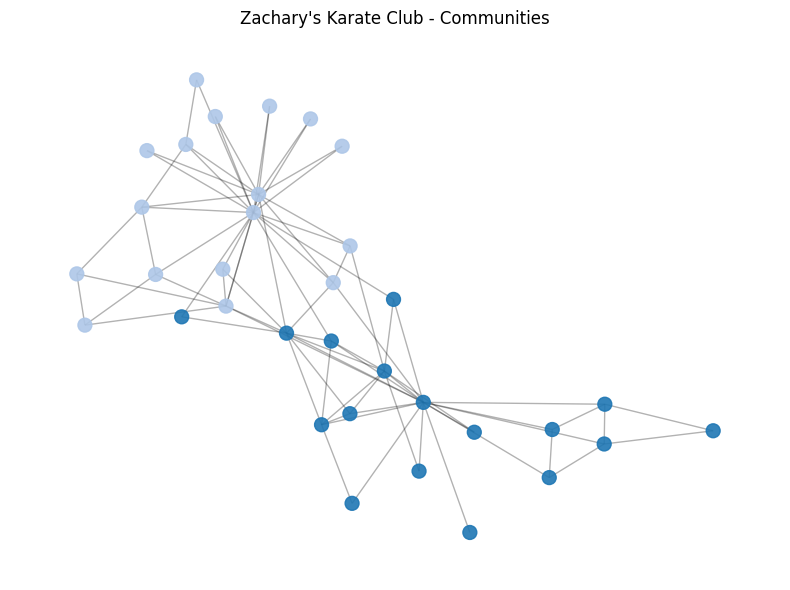

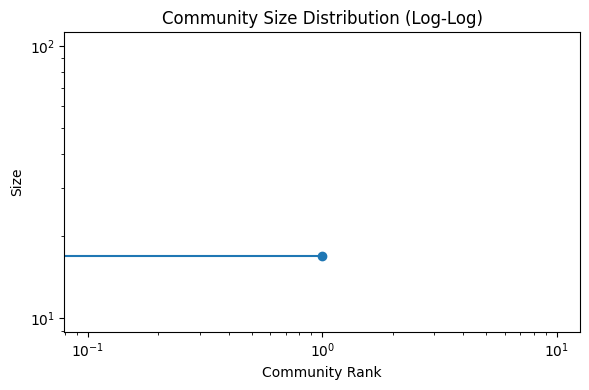

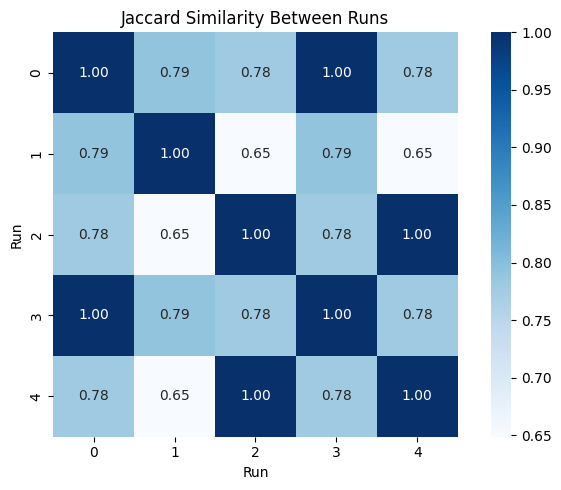

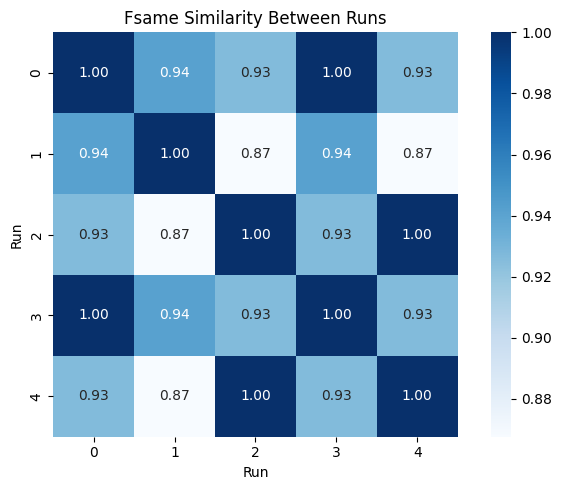

In [64]:
from tqdm import tqdm

# Choose dataset: "coauthorship", "www", "zachary" 
dataset = "zachary"

if dataset == "coauthorship":
    path = "/kaggle/input/graph-dataset/ca-CondMat.txt/CA-CondMat.txt"
    edges = read_edgelist(path)
elif dataset == "www":
    path = "/kaggle/input/graph-dataset/web-NotreDame.txt/web-NotreDame.txt"
    edges = read_edgelist(path)
elif dataset == "zachary":
    G = nx.read_gml("/kaggle/input/graph-dataset/karate.gml", label="id")
    edges = list(G.edges())
else:
    raise ValueError("Invalid dataset name.")


adj_list = build_adjacency_list(edges)

# Run Label Propagation multiple times 
runs = 5
all_communities = []
for i in tqdm(range(runs), desc="Running Label Propagation"):
    comms = label_propagation(adj_list)
    all_communities.append(comms)


print(f"Results for dataset: {dataset}")
evaluate(edges, all_communities[0])

# Visualization (only for Zachary)
if dataset == "zachary":
    draw_communities(edges, all_communities[0], title="Zachary's Karate Club - Communities")

plot_community_sizes(all_communities[0], loglog=True)

plot_similarity_heatmap(all_communities, metric='jaccard')
plot_similarity_heatmap(all_communities, metric='fsame')


Running Label Propagation: 100%|██████████| 5/5 [16:13<00:00, 194.74s/it]


Results for dataset: coauthorship
Modularity (Q): 0.6352
Number of communities: 2108
Top 5 community sizes: [312, 265, 235, 228, 225]


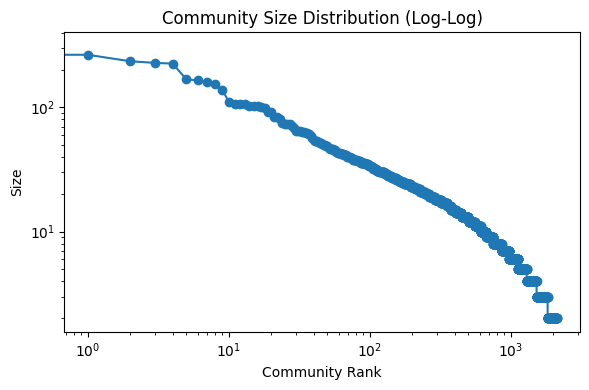

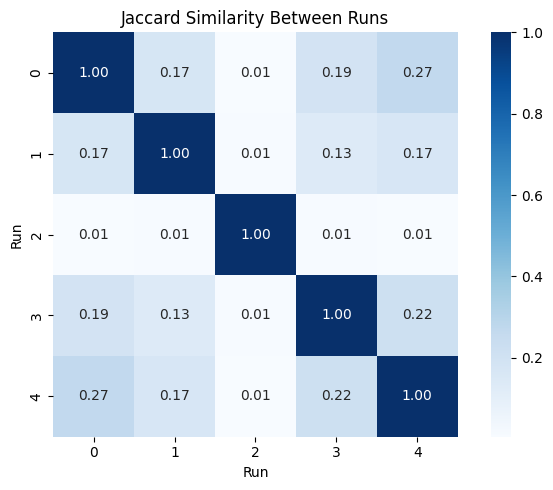

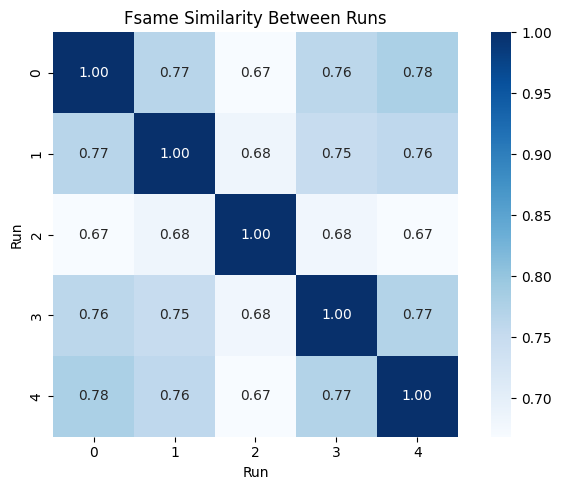

In [11]:
from tqdm import tqdm

# Choose dataset: "coauthorship", "www", "zachary" 
dataset = "coauthorship"

if dataset == "coauthorship":
    path = "/kaggle/input/graph-dataset/ca-CondMat.txt/CA-CondMat.txt"
    edges = read_edgelist(path)
elif dataset == "www":
    path = "/kaggle/input/graph-dataset/web-NotreDame.txt/web-NotreDame.txt"
    edges = read_edgelist(path)
elif dataset == "zachary":
    G = nx.read_gml("/kaggle/input/graph-dataset/karate.gml", label="id")
    edges = list(G.edges())
else:
    raise ValueError("Invalid dataset name.")

adj_list = build_adjacency_list(edges)

runs = 5
all_communities = []
for i in tqdm(range(runs), desc="Running Label Propagation"):
    comms = label_propagation(adj_list)
    all_communities.append(comms)

print(f"Results for dataset: {dataset}")
evaluate(edges, all_communities[0])

if dataset == "zachary":
    draw_communities(edges, all_communities[0], title="Zachary's Karate Club - Communities")

plot_community_sizes(all_communities[0], loglog=True)

plot_similarity_heatmap(all_communities, metric='jaccard')
plot_similarity_heatmap(all_communities, metric='fsame')


Running Label Propagation: 100%|██████████| 5/5 [3:18:07<00:00, 2377.55s/it]  


Results for dataset: www
Modularity (Q): 0.8435
Number of communities: 12611
Top 5 community sizes: [7552, 3192, 2890, 2660, 2646]


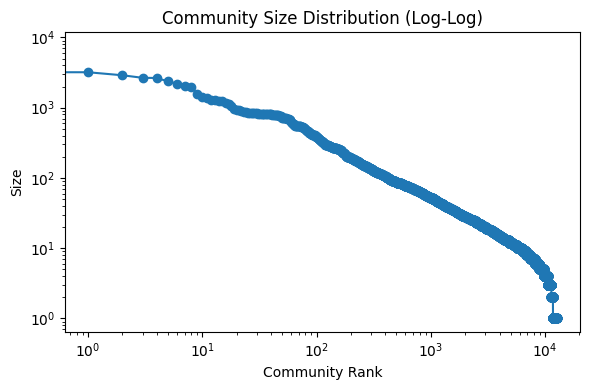

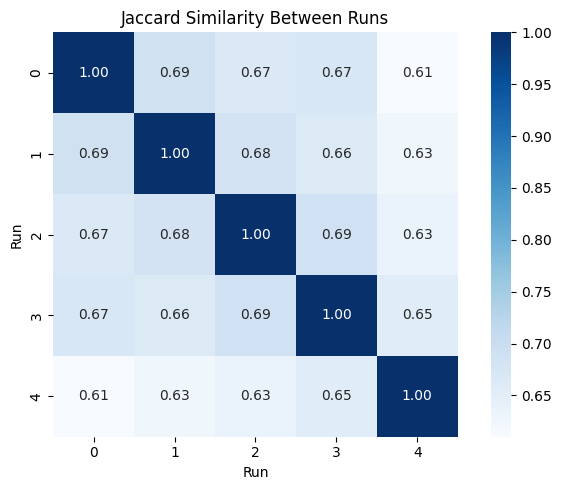

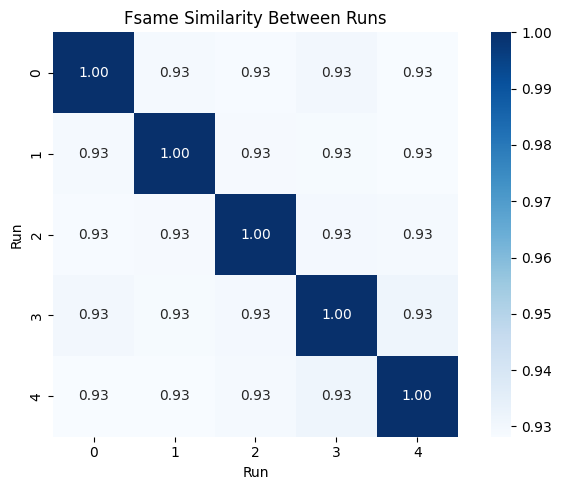

In [66]:
from tqdm import tqdm

# Choose dataset: "coauthorship", "www", "zachary" 
dataset = "www"

if dataset == "coauthorship":
    path = "/kaggle/input/graph-dataset/ca-CondMat.txt/CA-CondMat.txt"
    edges = read_edgelist(path)
elif dataset == "www":
    path = "/kaggle/input/graph-dataset/web-NotreDame.txt/web-NotreDame.txt"
    edges = read_edgelist(path)
elif dataset == "zachary":
    G = nx.read_gml("/kaggle/input/graph-dataset/karate.gml", label="id")
    edges = list(G.edges())
else:
    raise ValueError("Invalid dataset name.")

adj_list = build_adjacency_list(edges)

runs = 5
all_communities = []
for i in tqdm(range(runs), desc="Running Label Propagation"):
    comms = label_propagation(adj_list)
    all_communities.append(comms)

print(f"Results for dataset: {dataset}")
evaluate(edges, all_communities[0])

if dataset == "zachary":
    draw_communities(edges, all_communities[0], title="Zachary's Karate Club - Communities")

plot_community_sizes(all_communities[0], loglog=True)

plot_similarity_heatmap(all_communities, metric='jaccard')
plot_similarity_heatmap(all_communities, metric='fsame')


In [18]:
!pip install -q python-louvain

In [25]:
import community.community_louvain as community_louvain
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

def detect_louvain_communities(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    partition = community_louvain.best_partition(G)
    
    comms = defaultdict(list)
    for node, comm_id in partition.items():
        comms[comm_id].append(node)
    
    return list(comms.values()), G, partition

Modularity (Q): 0.4156
Number of communities: 4
Top 5 community sizes: [13, 12, 5, 4]


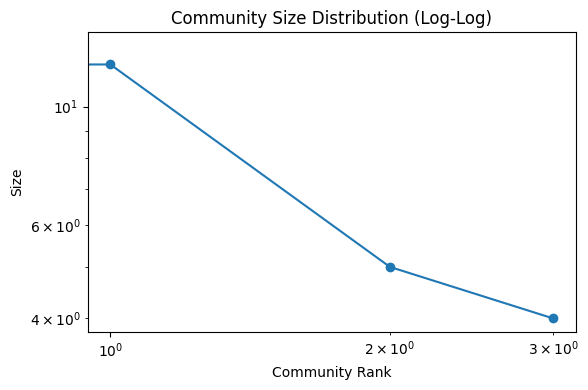

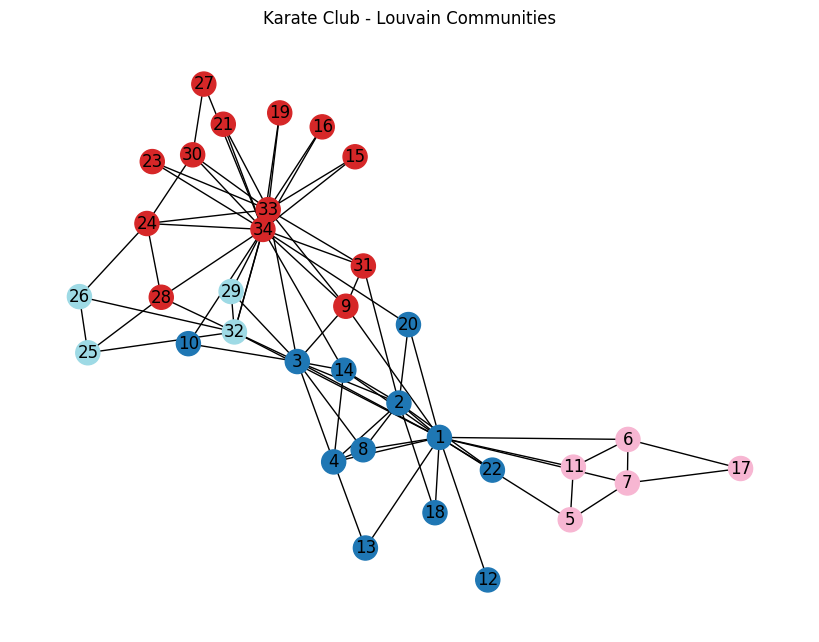

In [27]:
G = nx.read_gml("/kaggle/input/graph-dataset/karate.gml", label="id")
edges = list(G.edges())
communities_louvain, G_louvain, partition_louvain = detect_louvain_communities(edges)

# Modularity & community stats
modularity = community_louvain.modularity(partition_louvain, G_louvain)
print(f"Modularity (Q): {modularity:.4f}")
print(f"Number of communities: {len(communities_louvain)}")

sizes = sorted([len(c) for c in communities_louvain], reverse=True)
print("Top 5 community sizes:", sizes[:5])

# Plot (log-log)
plot_community_sizes(communities_louvain, loglog=True)

colors = [partition_louvain[node] for node in G_louvain.nodes()]
pos = nx.spring_layout(G_louvain, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G_louvain, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab20, node_size=300)
plt.title("Karate Club - Louvain Communities")
plt.show()


In [1]:
!pip install -q python-louvain

import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict, Counter
from tqdm import tqdm
import seaborn as sns
import numpy as np
import community.community_louvain as community_louvain 



=== Graph: karate ===


Running LPA: 100%|██████████| 5/5 [00:00<00:00, 1083.35it/s]

Modularity (Q) of Louvain: 0.4188
Louvain Communities: 4


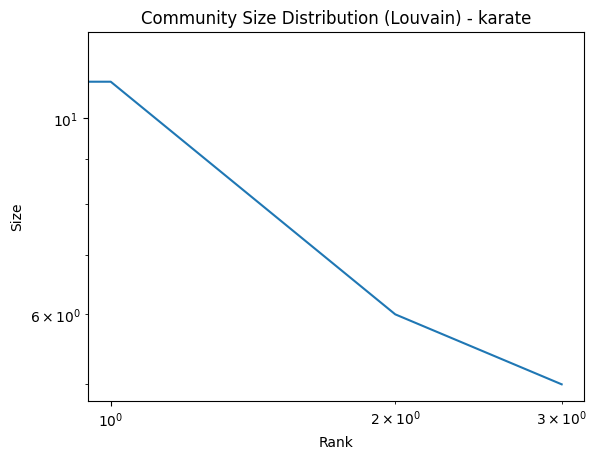

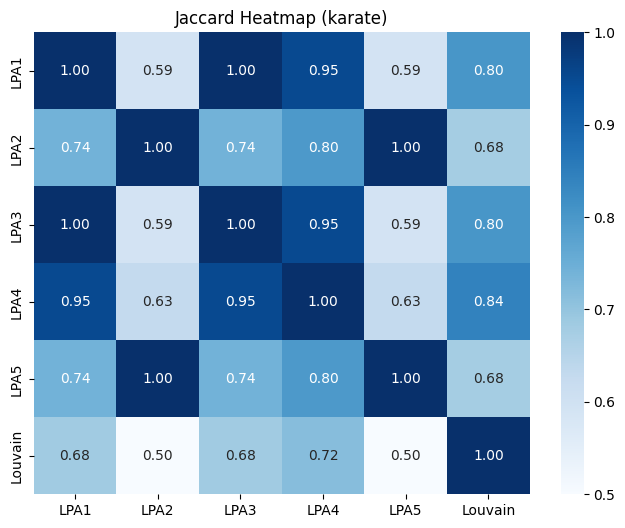

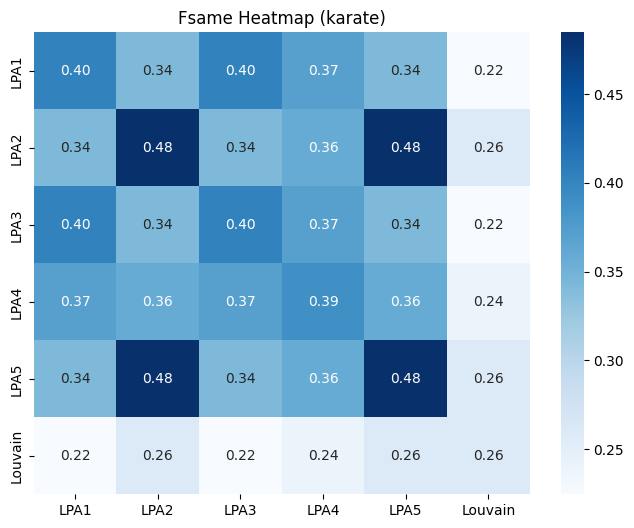

In [3]:

def read_edgelist(path):
    edges = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith("#"): continue
            u, v = map(int, line.strip().split()[:2])
            edges.append((int(u), int(v)))
    return edges

def build_adjacency_list(edges):
    adj = defaultdict(list)
    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
    return adj

def label_propagation(adj_list, max_iter=1000):
    labels = {node: node for node in adj_list}
    for _ in range(max_iter):
        nodes = list(adj_list.keys())
        random.shuffle(nodes)
        changed = False
        for node in nodes:
            neighbor_labels = [labels[n] for n in adj_list[node]]
            if not neighbor_labels: continue
            top = Counter(neighbor_labels).most_common()
            max_freq = top[0][1]
            top_labels = [lbl for lbl, freq in top if freq == max_freq]
            new_label = random.choice(top_labels)
            if labels[node] != new_label:
                labels[node] = new_label
                changed = True
        if not changed:
            break
    comms = defaultdict(list)
    for node, label in labels.items():
        comms[label].append(node)
    return list(comms.values())

def communities_to_dict(communities):
    return {node: i for i, comm in enumerate(communities) for node in comm}

def fsame(comm_a, comm_b):
    dict_a = communities_to_dict(comm_a)
    dict_b = communities_to_dict(comm_b)
    nodes = list(dict_a.keys())
    n = len(nodes)
    same = total = 0
    for i in range(n):
        for j in range(i+1, n):
            same_a = dict_a[nodes[i]] == dict_a[nodes[j]]
            same_b = dict_b[nodes[i]] == dict_b[nodes[j]]
            if same_a and same_b:
                same += 1
            total += 1
    return same / total if total else 0

def jaccard_similarity(comm_a, comm_b):
    best_scores = []
    for ca in comm_a:
        best = 0
        set_a = set(ca)
        for cb in comm_b:
            set_b = set(cb)
            intersect = len(set_a & set_b)
            union = len(set_a | set_b)
            if union > 0:
                best = max(best, intersect / union)
        best_scores.append(best)
    return sum(best_scores) / len(best_scores) if best_scores else 0

def plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=""):
    n = len(all_communities)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if metric == "fsame":
                matrix[i, j] = fsame(all_communities[i], all_communities[j])
            elif metric == "jaccard":
                matrix[i, j] = jaccard_similarity(all_communities[i], all_communities[j])
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)], 
                yticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)])
    plt.title(f"{metric.capitalize()} Heatmap {title_suffix}")
    plt.show()

# MAIN LOOP

graph_paths = [
    ("karate", "/kaggle/input/graph-dataset/karate.gml", "gml")
]

for name, path, filetype in graph_paths:
    print(f"\n=== Graph: {name} ===")

    if filetype == "gml":
        G = nx.read_gml(path, label="id")
        edges = list(G.edges())
    else:
        edges = read_edgelist(path)
        G = nx.Graph()
        G.add_edges_from(edges)

    adj_list = build_adjacency_list(edges)

    # 5 LPA runs
    lpa_runs = []
    for _ in tqdm(range(5), desc="Running LPA"):
        lpa_comm = label_propagation(adj_list)
        lpa_runs.append(lpa_comm)

    # Louvain
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    comms_louvain = defaultdict(list)
    for node, comm_id in partition.items():
        comms_louvain[comm_id].append(node)
    louvain_comm = list(comms_louvain.values())

    # Modularity
    Q = community_louvain.modularity(partition, G_undirected)
    print(f"Modularity (Q) of Louvain: {Q:.4f}")
    print(f"Louvain Communities: {len(louvain_comm)}")

    # Size distribution
    sizes = [len(c) for c in louvain_comm]
    plt.figure()
    plt.loglog(sorted(sizes, reverse=True))
    plt.title(f"Community Size Distribution (Louvain) - {name}")
    plt.xlabel("Rank")
    plt.ylabel("Size")
    plt.show()

    # Heatmaps
    all_communities = lpa_runs + [louvain_comm]
    plot_similarity_heatmap(all_communities, metric="jaccard", title_suffix=f"({name})")
    plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=f"({name})")



=== Graph: ca-CondMat ===
ERROR! Session/line number was not unique in database. History logging moved to new session 29


Running LPA: 100%|██████████| 5/5 [16:58<00:00, 203.71s/it]


Modularity (Q) of Louvain: 0.7325
Louvain Communities: 620


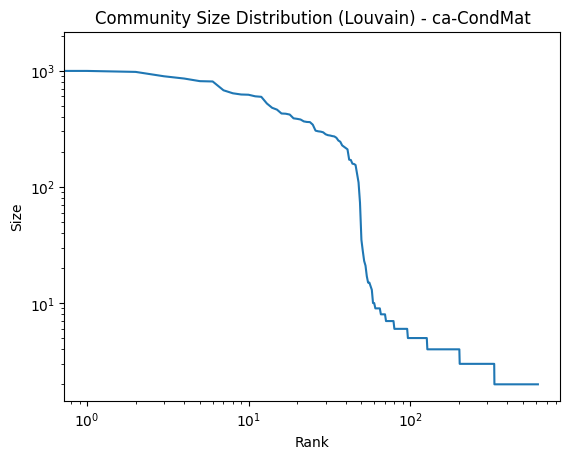

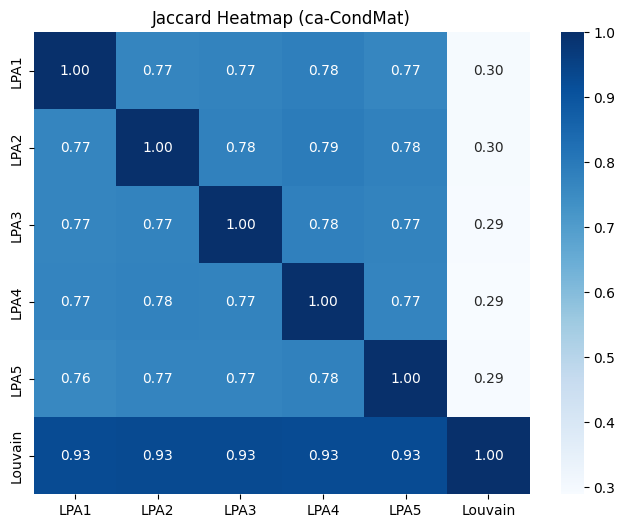

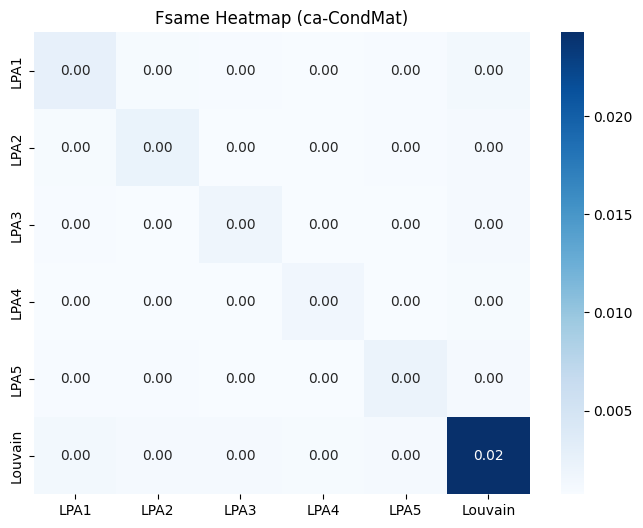

In [4]:

def read_edgelist(path):
    edges = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith("#"): continue
            u, v = map(int, line.strip().split()[:2])
            edges.append((int(u), int(v)))
    return edges

def build_adjacency_list(edges):
    adj = defaultdict(list)
    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
    return adj

def label_propagation(adj_list, max_iter=1000):
    labels = {node: node for node in adj_list}
    for _ in range(max_iter):
        nodes = list(adj_list.keys())
        random.shuffle(nodes)
        changed = False
        for node in nodes:
            neighbor_labels = [labels[n] for n in adj_list[node]]
            if not neighbor_labels: continue
            top = Counter(neighbor_labels).most_common()
            max_freq = top[0][1]
            top_labels = [lbl for lbl, freq in top if freq == max_freq]
            new_label = random.choice(top_labels)
            if labels[node] != new_label:
                labels[node] = new_label
                changed = True
        if not changed:
            break
    comms = defaultdict(list)
    for node, label in labels.items():
        comms[label].append(node)
    return list(comms.values())

def communities_to_dict(communities):
    return {node: i for i, comm in enumerate(communities) for node in comm}

def fsame(comm_a, comm_b):
    dict_a = communities_to_dict(comm_a)
    dict_b = communities_to_dict(comm_b)
    nodes = list(dict_a.keys())
    n = len(nodes)
    same = total = 0
    for i in range(n):
        for j in range(i+1, n):
            same_a = dict_a[nodes[i]] == dict_a[nodes[j]]
            same_b = dict_b[nodes[i]] == dict_b[nodes[j]]
            if same_a and same_b:
                same += 1
            total += 1
    return same / total if total else 0

def jaccard_similarity(comm_a, comm_b):
    best_scores = []
    for ca in comm_a:
        best = 0
        set_a = set(ca)
        for cb in comm_b:
            set_b = set(cb)
            intersect = len(set_a & set_b)
            union = len(set_a | set_b)
            if union > 0:
                best = max(best, intersect / union)
        best_scores.append(best)
    return sum(best_scores) / len(best_scores) if best_scores else 0

def plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=""):
    n = len(all_communities)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if metric == "fsame":
                matrix[i, j] = fsame(all_communities[i], all_communities[j])
            elif metric == "jaccard":
                matrix[i, j] = jaccard_similarity(all_communities[i], all_communities[j])
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)], 
                yticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)])
    plt.title(f"{metric.capitalize()} Heatmap {title_suffix}")
    plt.show()


graph_paths = [
    ("ca-CondMat", "/kaggle/input/graph-dataset/ca-CondMat.txt/CA-CondMat.txt", "txt")
]

for name, path, filetype in graph_paths:
    print(f"\n=== Graph: {name} ===")

    if filetype == "gml":
        G = nx.read_gml(path, label="id")
        edges = list(G.edges())
    else:
        edges = read_edgelist(path)
        G = nx.Graph()
        G.add_edges_from(edges)

    adj_list = build_adjacency_list(edges)

    # 5 LPA runs
    lpa_runs = []
    for _ in tqdm(range(5), desc="Running LPA"):
        lpa_comm = label_propagation(adj_list)
        lpa_runs.append(lpa_comm)

    # Louvain
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    comms_louvain = defaultdict(list)
    for node, comm_id in partition.items():
        comms_louvain[comm_id].append(node)
    louvain_comm = list(comms_louvain.values())

    # Modularity
    Q = community_louvain.modularity(partition, G_undirected)
    print(f"Modularity (Q) of Louvain: {Q:.4f}")
    print(f"Louvain Communities: {len(louvain_comm)}")

    # Size distribution
    sizes = [len(c) for c in louvain_comm]
    plt.figure()
    plt.loglog(sorted(sizes, reverse=True))
    plt.title(f"Community Size Distribution (Louvain) - {name}")
    plt.xlabel("Rank")
    plt.ylabel("Size")
    plt.show()

    # Heatmaps
    all_communities = lpa_runs + [louvain_comm]
    plot_similarity_heatmap(all_communities, metric="jaccard", title_suffix=f"({name})")
    plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=f"({name})")



=== Graph: web-NotreDame ===


Running LPA: 100%|██████████| 5/5 [2:54:04<00:00, 2088.93s/it]  


Modularity (Q) of Louvain: 0.9372
Louvain Communities: 520


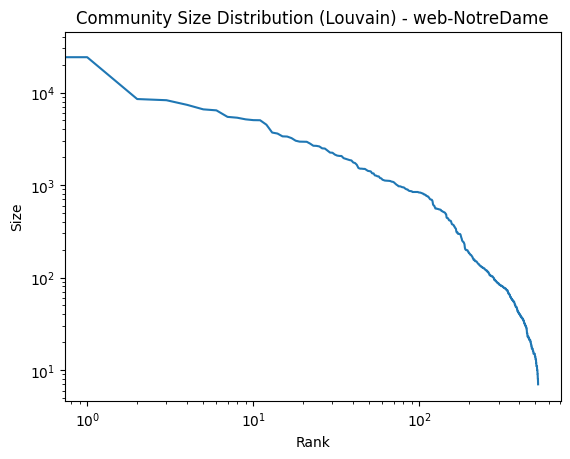

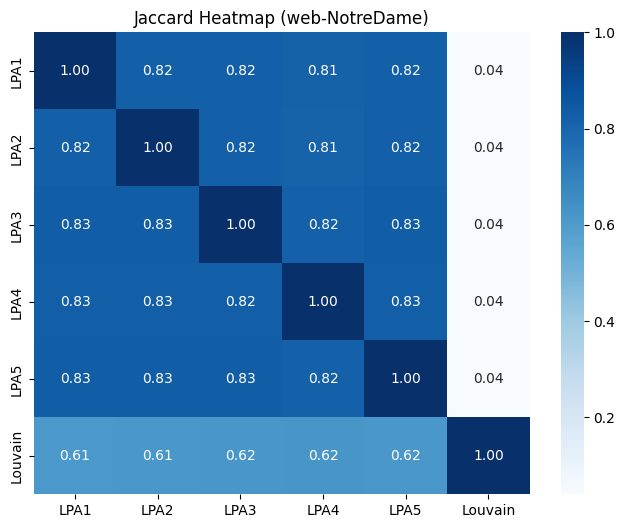

In [ ]:
def read_edgelist(path):
    edges = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith("#"): continue
            u, v = map(int, line.strip().split()[:2])
            edges.append((int(u), int(v)))
    return edges

def build_adjacency_list(edges):
    adj = defaultdict(list)
    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
    return adj

def label_propagation(adj_list, max_iter=1000):
    labels = {node: node for node in adj_list}
    for _ in range(max_iter):
        nodes = list(adj_list.keys())
        random.shuffle(nodes)
        changed = False
        for node in nodes:
            neighbor_labels = [labels[n] for n in adj_list[node]]
            if not neighbor_labels: continue
            top = Counter(neighbor_labels).most_common()
            max_freq = top[0][1]
            top_labels = [lbl for lbl, freq in top if freq == max_freq]
            new_label = random.choice(top_labels)
            if labels[node] != new_label:
                labels[node] = new_label
                changed = True
        if not changed:
            break
    comms = defaultdict(list)
    for node, label in labels.items():
        comms[label].append(node)
    return list(comms.values())

def communities_to_dict(communities):
    return {node: i for i, comm in enumerate(communities) for node in comm}

def fsame(comm_a, comm_b):
    dict_a = communities_to_dict(comm_a)
    dict_b = communities_to_dict(comm_b)
    nodes = list(dict_a.keys())
    n = len(nodes)
    same = total = 0
    for i in range(n):
        for j in range(i+1, n):
            same_a = dict_a[nodes[i]] == dict_a[nodes[j]]
            same_b = dict_b[nodes[i]] == dict_b[nodes[j]]
            if same_a and same_b:
                same += 1
            total += 1
    return same / total if total else 0

def jaccard_similarity(comm_a, comm_b):
    best_scores = []
    for ca in comm_a:
        best = 0
        set_a = set(ca)
        for cb in comm_b:
            set_b = set(cb)
            intersect = len(set_a & set_b)
            union = len(set_a | set_b)
            if union > 0:
                best = max(best, intersect / union)
        best_scores.append(best)
    return sum(best_scores) / len(best_scores) if best_scores else 0

def plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=""):
    n = len(all_communities)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if metric == "fsame":
                matrix[i, j] = fsame(all_communities[i], all_communities[j])
            elif metric == "jaccard":
                matrix[i, j] = jaccard_similarity(all_communities[i], all_communities[j])
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)], 
                yticklabels=[f"LPA{i+1}" if i < n-1 else "Louvain" for i in range(n)])
    plt.title(f"{metric.capitalize()} Heatmap {title_suffix}")
    plt.show()

# MAIN LOOP

graph_paths = [
    ("web-NotreDame", "/kaggle/input/graph-dataset/web-NotreDame.txt/web-NotreDame.txt", "txt")
]

for name, path, filetype in graph_paths:
    print(f"\n=== Graph: {name} ===")

    if filetype == "gml":
        G = nx.read_gml(path, label="id")
        edges = list(G.edges())
    else:
        edges = read_edgelist(path)
        G = nx.Graph()
        G.add_edges_from(edges)

    adj_list = build_adjacency_list(edges)

    # 5 LPA runs
    lpa_runs = []
    for _ in tqdm(range(5), desc="Running LPA"):
        lpa_comm = label_propagation(adj_list)
        lpa_runs.append(lpa_comm)

    # Louvain
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)
    comms_louvain = defaultdict(list)
    for node, comm_id in partition.items():
        comms_louvain[comm_id].append(node)
    louvain_comm = list(comms_louvain.values())

    # Modularity
    Q = community_louvain.modularity(partition, G_undirected)
    print(f"Modularity (Q) of Louvain: {Q:.4f}")
    print(f"Louvain Communities: {len(louvain_comm)}")

    # Size distribution
    sizes = [len(c) for c in louvain_comm]
    plt.figure()
    plt.loglog(sorted(sizes, reverse=True))
    plt.title(f"Community Size Distribution (Louvain) - {name}")
    plt.xlabel("Rank")
    plt.ylabel("Size")
    plt.show()

    # Heatmaps
    all_communities = lpa_runs + [louvain_comm]
    plot_similarity_heatmap(all_communities, metric="jaccard", title_suffix=f"({name})")
    plot_similarity_heatmap(all_communities, metric="fsame", title_suffix=f"({name})")
